In [1]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-11-13 17:00:54.582274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 17:00:54.592057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 17:00:54.594940: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
model = ['nl']
label = ['NL']
x_names = [f"R_{i}" for i in range(100)]

dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']

x_ncols = len(x_names)
nrows, data = mchain['nlines'][0], mchain['data']
X = np.zeros((x_ncols, nrows))

for i in range(x_ncols):
    X[i] = data[x_names[i]]
Y = np.array(data['R_max']).reshape(-1, 1)

X = X.T

scaler_X = MinMaxScaler(feature_range=(0, 1))

# Mask and scale non-zero values in X
nz = X != 0
x = np.copy(X)  # Copy X to keep zeros intact
x[nz] = scaler_X.fit_transform(X[nz].reshape(-1, 1)).flatten()

# Scale Y with the same scaler as X
y = scaler_X.transform(Y)

x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

#min_x = np.array([np.min(row[row != 0]) for row in x])
#plt.plot(np.sort(min_x, axis=0), label='r_max')
#plt.plot(np.sort(y.flatten(), axis=0), label='R_max')
#plt.legend()
#plt.show()

In [3]:
tuner_dir = 'trials2'

if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Memory growth enabled for the first GPU.")
    except RuntimeError as e:
        print(f"Could not enable memory growth: {e}")
else:
    print("No GPUs found.")

Memory growth enabled for the first GPU.


I0000 00:00:1731535256.006872  300723 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731535256.028987  300723 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731535256.030151  300723 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
def build_model(hp):

    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(100,)))
    
    for i in range(hp.Int('num_layers', 2, 3)):
        units = hp.Choice(f'units_{i}', [32, 64, 128, 256])
        model.add(layers.Dense(units=units, activation='relu'))
    
    model.add(layers.Dense(units=1, activation='sigmoid'))
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse']
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory='trials2',
)

tuner.search_space_summary()

I0000 00:00:1731535256.042640  300723 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731535256.045604  300723 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731535256.048550  300723 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731535256.167277  300723 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
units_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}


In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=5
)

tuner.search(
    x_tr, y_tr,
    validation_data=(x_ts, y_ts),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop]
)

Trial 100 Complete [00h 00m 10s]
val_loss: 0.000561097520403564

Best val_loss So Far: 0.0003198682388756424
Total elapsed time: 00h 13m 05s


In [6]:
tuner.results_summary(num_trials=10)

Results summary
Results in trials2/untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 061 summary
Hyperparameters:
num_layers: 3
units_0: 32
units_1: 128
units_2: 256
Score: 0.0003198682388756424

Trial 018 summary
Hyperparameters:
num_layers: 3
units_0: 256
units_1: 256
units_2: 32
Score: 0.00034237251384183764

Trial 064 summary
Hyperparameters:
num_layers: 3
units_0: 256
units_1: 256
units_2: 256
Score: 0.0003603372897487134

Trial 049 summary
Hyperparameters:
num_layers: 3
units_0: 64
units_1: 256
units_2: 256
Score: 0.00037774263182654977

Trial 048 summary
Hyperparameters:
num_layers: 3
units_0: 32
units_1: 256
units_2: 64
Score: 0.00039003664278425276

Trial 043 summary
Hyperparameters:
num_layers: 3
units_0: 256
units_1: 64
units_2: 64
Score: 0.0003931055834982544

Trial 020 summary
Hyperparameters:
num_layers: 3
units_0: 128
units_1: 32
units_2: 64
Score: 0.0003931674873456359

Trial 003 summary
Hyperparameters:
num_layers: 2
units_0: 25

In [7]:
# Retrieve the best model and evaluate
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,737 (159.13 KB)

 Trainable params: 40,737 (159.13 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-5, 
    patience=5
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)

# Optionally, retrain on the full dataset with optimal hyperparameters
training = best_model.fit(x_tr, y_tr, epochs=1000, validation_data=(x_ts, y_ts), \
                          batch_size=128, callbacks=[early_stop, lr_schedule])

Epoch 1/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0035 - val_mse: 0.0035 - learning_rate: 0.0010
Epoch 2/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0026 - val_mse: 0.0026 - learning_rate: 0.0010
Epoch 3/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0019 - val_mse: 0.0019 - learning_rate: 0.0010
Epoch 4/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0014 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 5/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 6/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 7/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011 - learning_rate: 

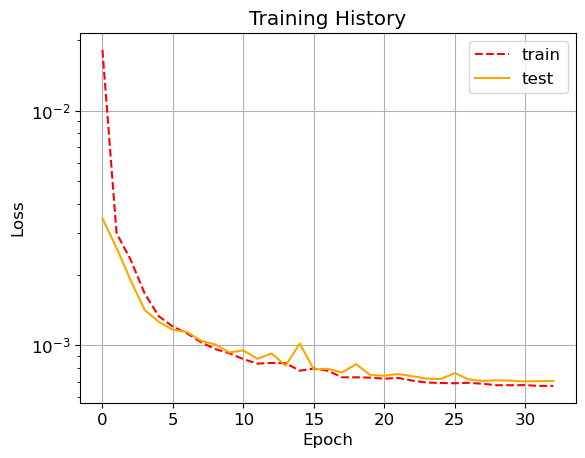

In [9]:
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


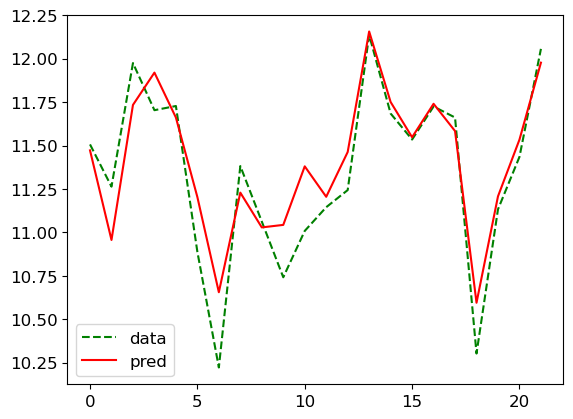

In [12]:
y_pr = best_model.predict(x_vl)
Y_pr = scaler_X.inverse_transform(y_pr).flatten()
Y_vl = scaler_X.inverse_transform(y_vl).flatten()
plt.plot(Y_vl, c='green', label='data', ls='--')
plt.plot(Y_pr, c='red', label='pred')
plt.legend()
plt.show()